<a href="https://colab.research.google.com/github/EnsarIshakoglu/NLP/blob/topic-modelling/NLP_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Source: https://keras.io/examples/nlp/multi_label_classification/#introduction
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from ast import literal_eval

# Tensorflow
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa

# Keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, Input
from keras.layers import Dense, Conv1D, SeparableConv1D, BatchNormalization, MaxPool1D, Dropout, Flatten, Embedding

# SKlearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE

# Data processing
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Stackapi to fetch stackoverflow api
!pip install stackapi
from stackapi import StackAPI

# Gensim
!pip install --upgrade gensim
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim import models

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .mio5_utils import VarReader5


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Mount colab drive to google drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fetch data

In [12]:
# Get the data from stackoverflow sorted by votes
def fetch_data():
  data = []
  page_count = 40
  SITE = StackAPI('stackoverflow')

  for i in range(page_count):
    data.append(SITE.fetch('questions', sort="votes", min=20, filter='withbody', page=i + 1))
  
  return data

## Remove useless data

In [13]:
def clean_data(data):
  raw_df = pd.DataFrame(pd.DataFrame.from_dict(data[0]['items']))
  for i in range(len(data) - 1):
    raw_df = raw_df.append(pd.DataFrame.from_dict(data[i + 1]['items']))
  
  df = raw_df[['tags', 'body']]

  # Strip html tags with regex:
  df['body'] = df['body'].str.replace(r'<[^<>]*>', '', regex=True)

  # Get first tag for multi-class classification
  row_count = df.shape[0]

  for i in range(row_count):
    df['tags'].iloc[i] = df['tags'].iloc[i][0]
  
  return df

### Create folder and file from df, unmout drive after

In [14]:
from os.path import exists

!mkdir stackoverflow

if not exists('/content/stackoverflow/questions.csv'):
  data = fetch_data()
  df = clean_data(data)
  df.to_csv('/content/stackoverflow/questions.csv')
  print("Fetched data from stackoverflow, removed the useless data and saved it in stackoverflow/questions.csv")

drive.flush_and_unmount()

mkdir: cannot create directory ‘stackoverflow’: File exists


### Load file from drive

In [15]:
df = pd.read_csv('/content/stackoverflow/questions.csv')

df.head()

,Unnamed: 0,tags,owner,is_answered,view_count,protected_date,accepted_answer_id,answer_count,score,last_activity_date,creation_date,last_edit_date,question_id,content_license,link,title,body,community_owned_date,locked_date,closed_date,closed_reason,migrated_from
0,0,"['java', 'c++', 'performance', 'cpu-architectu...","{'reputation': 469918, 'user_id': 87234, 'user...",True,1662469,1.399067e+09,11227902.0,29,26031,1636434375,1340805096,1.634760e+09,11227809,CC BY-SA 4.0,https://stackoverflow.com/questions/11227809/w...,Why is processing a sorted array faster than p...,<p>Here is a piece of C++ code that shows some...,NaN,NaN,NaN,NaN,NaN
1,1,"['git', 'version-control', 'git-commit', 'undo']","{'reputation': 47989, 'user_id': 89904, 'user_...",True,10254767,1.370840e+09,927386.0,100,23542,1637838948,1243620554,1.625030e+09,927358,CC BY-SA 4.0,https://stackoverflow.com/questions/927358/how...,How do I undo the most recent local commits in...,<p>I accidentally <strong>committed the wrong ...,1.363429e+09,NaN,NaN,NaN,NaN
2,2,"['git', 'version-control', 'git-branch', 'git-...","{'reputation': 416782, 'user_id': 95592, 'user...",True,9430056,1.358718e+09,2003515.0,41,18667,1638336685,1262653935,1.633560e+09,2003505,CC BY-SA 4.0,https://stackoverflow.com/questions/2003505/ho...,How do I delete a Git branch locally and remot...,<p>I want to delete a branch both locally and ...,NaN,NaN,NaN,NaN,NaN
3,3,"['git', 'version-control', 'git-pull', 'git-fe...","{'reputation': 264138, 'user_id': 6068, 'user_...",True,3071149,1.362879e+09,292359.0,38,12908,1636728187,1226742669,1.606493e+09,292357,CC BY-SA 4.0,https://stackoverflow.com/questions/292357/wha...,What is the difference between &#39;git pull&#...,<p>What are the differences between <code>git ...,NaN,NaN,NaN,NaN,NaN
4,4,"['python', 'iterator', 'generator', 'yield', '...","{'reputation': 131777, 'user_id': 18300, 'user...",True,2731894,1.360547e+09,231855.0,43,11664,1636440019,1224800471,1.633986e+09,231767,CC BY-SA 4.0,https://stackoverflow.com/questions/231767/wha...,What does the &quot;yield&quot; keyword do?,<p>What is the use of the <code>yield</code> k...,NaN,NaN,NaN,NaN,NaN


In [16]:
print(f"There are {len(df['body'].unique())} rows in the dataset.")

There are 3900 rows in the dataset.


In [17]:
df = df[~df['body'].duplicated()]
print(f"There are {len(df)} rows in the deduplicated dataset.")

There are 3900 rows in the deduplicated dataset.


In [18]:
# There are a lot of terms with occurrence below 40.
threshold = 40

print(sum(df['tags'].value_counts() < threshold))

# How many unique terms?
print(df['tags'].nunique())

3317
3318


In [19]:
# Filtering the rare terms because there is not enough data to train properly with.
df_filtered = df.groupby("tags").filter(lambda x: len(x) > threshold)
df_filtered.shape

(61, 22)

In [20]:
# # Remove punctuation
# df_filtered['body'] = df_filtered['body'].replace('[^\w\s]','', regex=True)
# df_filtered['body'] = df_filtered['body'].replace(r'\s+|\\n', ' ', regex=True) 
    
# df_filtered.head()

In [21]:
# Source: https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe

stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df_filtered['body'] = df_filtered['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_filtered.head()

,Unnamed: 0,tags,owner,is_answered,view_count,protected_date,accepted_answer_id,answer_count,score,last_activity_date,creation_date,last_edit_date,question_id,content_license,link,title,body,community_owned_date,locked_date,closed_date,closed_reason,migrated_from
470,470,['git'],"{'reputation': 21892, 'user_id': 39758, 'user_...",True,804018,1.529411e+09,936290.0,20,1935,1617169294,1243883296,1.479563e+09,936249,CC BY-SA 3.0,https://stackoverflow.com/questions/936249/how...,How to stop tracking and ignore changes to a f...,<p>I cloned project includes <code>.csproj</co...,NaN,NaN,NaN,NaN,NaN
905,905,['git'],"{'reputation': 33616, 'user_id': 101152, 'user...",True,843120,NaN,2763118.0,15,1881,1636462398,1272951052,1.507462e+09,2763006,CC BY-SA 3.0,https://stackoverflow.com/questions/2763006/ma...,Make the current Git branch a master branch,"<p>I repository Git. I made branch, changes ma...",NaN,NaN,NaN,NaN,NaN
914,914,['git'],"{'reputation': 41654, 'user_id': 27358, 'user_...",True,1312743,NaN,5097495.0,21,1871,1636390741,1298496835,1.549057e+09,5097456,CC BY-SA 4.0,https://stackoverflow.com/questions/5097456/th...,Throw away local commits in Git,"<p>Due bad cherry-picking, local Git repositor...",NaN,NaN,NaN,NaN,NaN
1424,1424,['git'],"{'reputation': 68102, 'user_id': 73297, 'user_...",True,1100433,1.545281e+09,5772882.0,28,1671,1634800354,1303667461,1.496082e+09,5772192,CC BY-SA 3.0,https://stackoverflow.com/questions/5772192/ho...,How can I reconcile detached HEAD with master/...,<p>I'm new branching complexities Git. I alway...,NaN,NaN,NaN,NaN,NaN
1469,1469,['git'],"{'reputation': 52282, 'user_id': 74865, 'user_...",True,604954,NaN,2531803.0,4,1609,1608024775,1269454109,1.608025e+09,2510276,CC BY-SA 4.0,https://stackoverflow.com/questions/2510276/ho...,How to undo &#39;git reset&#39;?,<p>What's simplest way undo:</p> <pre><code>gi...,NaN,NaN,NaN,NaN,NaN


In [22]:
# Source: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Lemmatize words
lemmatizer = WordNetLemmatizer()
df_filtered['body'] = df_filtered['body'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in x.split()]))
df_filtered.head()

,Unnamed: 0,tags,owner,is_answered,view_count,protected_date,accepted_answer_id,answer_count,score,last_activity_date,creation_date,last_edit_date,question_id,content_license,link,title,body,community_owned_date,locked_date,closed_date,closed_reason,migrated_from
470,470,['git'],"{'reputation': 21892, 'user_id': 39758, 'user_...",True,804018,1.529411e+09,936290.0,20,1935,1617169294,1243883296,1.479563e+09,936249,CC BY-SA 3.0,https://stackoverflow.com/questions/936249/how...,How to stop tracking and ignore changes to a f...,<p>I clone project include <code>.csproj</code...,NaN,NaN,NaN,NaN,NaN
905,905,['git'],"{'reputation': 33616, 'user_id': 101152, 'user...",True,843120,NaN,2763118.0,15,1881,1636462398,1272951052,1.507462e+09,2763006,CC BY-SA 3.0,https://stackoverflow.com/questions/2763006/ma...,Make the current Git branch a master branch,"<p>I repository Git. I make branch, change mas...",NaN,NaN,NaN,NaN,NaN
914,914,['git'],"{'reputation': 41654, 'user_id': 27358, 'user_...",True,1312743,NaN,5097495.0,21,1871,1636390741,1298496835,1.549057e+09,5097456,CC BY-SA 4.0,https://stackoverflow.com/questions/5097456/th...,Throw away local commits in Git,"<p>Due bad cherry-picking, local Git repositor...",NaN,NaN,NaN,NaN,NaN
1424,1424,['git'],"{'reputation': 68102, 'user_id': 73297, 'user_...",True,1100433,1.545281e+09,5772882.0,28,1671,1634800354,1303667461,1.496082e+09,5772192,CC BY-SA 3.0,https://stackoverflow.com/questions/5772192/ho...,How can I reconcile detached HEAD with master/...,<p>I'm new branching complexity Git. I always ...,NaN,NaN,NaN,NaN,NaN
1469,1469,['git'],"{'reputation': 52282, 'user_id': 74865, 'user_...",True,604954,NaN,2531803.0,4,1609,1608024775,1269454109,1.608025e+09,2510276,CC BY-SA 4.0,https://stackoverflow.com/questions/2510276/ho...,How to undo &#39;git reset&#39;?,<p>What's simplest way undo:</p> <pre><code>gi...,NaN,NaN,NaN,NaN,NaN


In [23]:
# Check class imbalance:
print(df_filtered.groupby(df_filtered['tags']).size())

tags
['git']    61
dtype: int64


## Prepare data

In [24]:
df = df_filtered[['title', 'body']]
df.head()

,title,body
470,How to stop tracking and ignore changes to a f...,<p>I clone project include <code>.csproj</code...
905,Make the current Git branch a master branch,"<p>I repository Git. I make branch, change mas..."
914,Throw away local commits in Git,"<p>Due bad cherry-picking, local Git repositor..."
1424,How can I reconcile detached HEAD with master/...,<p>I'm new branching complexity Git. I always ...
1469,How to undo &#39;git reset&#39;?,<p>What's simplest way undo:</p> <pre><code>gi...


In [25]:
texts = df.body.apply(simple_preprocess)

In [26]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in texts]

In [27]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [28]:
n_topics = 15

# Build an LSI model
lsi_model = models.LsiModel(corpus_tfidf,
                            id2word=dictionary,
                            num_topics=n_topics)

In [29]:
lsi_model.print_topics()

[(0,
  '-0.233*"file" + -0.223*"commit" + -0.219*"branch" + -0.199*"remote" + -0.186*"pre" + -0.172*"new" + -0.164*"em" + -0.162*"repository" + -0.158*"master" + -0.151*"commits"'),
 (1,
  '-0.435*"gt" + -0.424*"lt" + 0.263*"remote" + -0.244*"head" + -0.220*"reset" + 0.219*"branch" + 0.209*"local" + -0.204*"directory" + -0.195*"revert" + -0.147*"hard"'),
 (2,
  '-0.424*"file" + -0.320*"line" + 0.288*"branch" + 0.270*"remote" + 0.259*"master" + 0.197*"origin" + 0.187*"push" + 0.176*"pre" + -0.160*"add" + 0.159*"gt"'),
 (3,
  '-0.383*"line" + 0.339*"clone" + -0.325*"em" + 0.322*"directory" + 0.201*"repo" + 0.197*"project" + -0.194*"commits" + 0.156*"file" + -0.148*"commit" + -0.144*"log"'),
 (4,
  '0.453*"head" + -0.257*"lt" + -0.240*"commit" + -0.235*"gt" + 0.215*"version" + 0.193*"like" + 0.193*"line" + 0.188*"exactly" + 0.184*"reset" + 0.172*"pull"'),
 (5,
  '-0.333*"branch" + 0.324*"clone" + -0.264*"head" + -0.261*"delete" + 0.240*"push" + 0.224*"pull" + -0.214*"how" + -0.184*"commit

In [30]:
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(lsi_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

topic_words.head()

,value,word,topic
0,-0.040722,sure,0
1,-0.041311,everything,0
2,-0.044203,href,0
3,-0.047512,do,0
4,-0.048334,manually,0


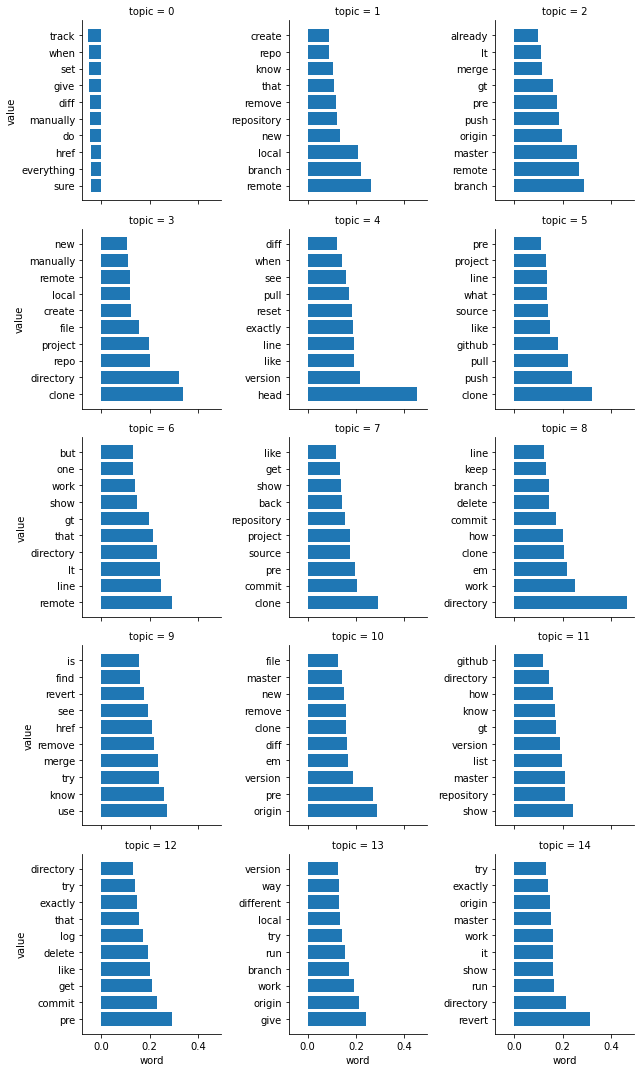

In [31]:
g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")

## Using LDA with Gensim

In [32]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models.ldamodel import LdaModel

In [33]:
n_topics = 15
pyLDAvis.enable_notebook()

lda_model = LdaModel(corpus=corpus, num_topics=n_topics)

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)
lda_viz

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.025913 -0.001777       1        1  17.997285
9     -0.091097 -0.001033       2        1  13.481149
6      0.037092 -0.082093       3        1  11.608277
8      0.032761 -0.002425       4        1   9.349655
5     -0.107031  0.013769       5        1   7.528710
4     -0.109267  0.047202       6        1   6.234061
11    -0.052354  0.200532       7        1   6.211376
14    -0.031922  0.086483       8        1   6.009831
13    -0.189841 -0.130430       9        1   5.095076
12    -0.001690 -0.074362      10        1   4.690668
10     0.121938  0.121376      11        1   3.503534
2      0.095586 -0.013673      12        1   3.079043
7      0.186964 -0.018117      13        1   2.463864
3      0.073289 -0.166918      14        1   1.934091
0      0.009660  0.021468      15        1   0.813378, topic_info=      Term       Freq      Total Category  logprob  loglift
58    head  19.000000  19.000000  Default  30.0000  30.0000
6     file  77.000000  77.000000  Default  29.0000  29.0000
67     pre  52.000000  52.000000  Default  28.0000  28.0000
64  remote  36.000000  36.000000  Default  27.0000  27.0000
25  branch  53.000000  53.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
72      gt   0.052726  30.486746  Topic15  -5.4205  -1.5482
31      it   0.052726  17.239527  Topic15  -5.4205  -0.9781
47     get   0.052726  18.244452  Topic15  -5.4205  -1.0348
73      lt   0.052726  21.927984  Topic15  -5.4205  -1.2187
16    repo   0.052726  12.962960  Topic15  -5.4205  -0.6930

[616 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         2  0.168519    add
0         3  0.084259    add
0         4  0.084259    add
0         5  0.252778    add
0         6  0.084259    add
...     ...       ...    ...
54        3  0.179628  would
54        4  0.089814  would
54        5  0.179628  would
54        8  0.089814  would
54       13  0.089814  would

[597 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 7, 9, 6, 5, 12, 15, 14, 13, 11, 3, 8, 4, 1])

## OLD

In [ ]:
df_filtered['label'] = pd.factorize(df_filtered['tags'])[0]
df_filtered.head()

In [ ]:
# vectorizer = CountVectorizer(min_df=0, lowercase=False)
# vectorizer.fit(df_filtered['body'])
# vectorizer.transform(df_filtered['body']).toarray()

In [ ]:
# Use stratified splits because of class imbalance
X = df_filtered['body']
y = df_filtered['label']

# Initial train and test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=132)

# Splitting the test set further into validation and new test sets.
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=23)

print(f"Number of rows in training set: {len(X_train)}")
print(f"Number of rows in validation set: {len(X_val)}")
print(f"Number of rows in test set: {len(X_test)}")

In [ ]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_val = vectorizer.transform(X_val)

In [ ]:
# Dataset preview
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_train shape: {y_train.shape}')

## Create model

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color="white").generate(' '.join(df_filtered['body']))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Amount of columns in data:
input_dim = X_train.shape[1]

# Amount of unique labels:
output_dim = y_train.nunique()

print(f'Input dim: {input_dim}')
print(f'Output dim: {output_dim}')

In [ ]:
# Reshape labels
label_encoder = LabelEncoder()
y_train = np.array(label_encoder.fit_transform(y_train))
y_val = np.array(label_encoder.fit_transform(y_val))
y_test = np.array(label_encoder.fit_transform(y_test))

y_train = tf.one_hot(y_train, depth=output_dim)
y_val = tf.one_hot(y_val, depth=output_dim)
y_test = tf.one_hot(y_test, depth=output_dim)

In [ ]:
# First define baseline model. Then use it in Keras Classifier for the training
def baseline_model():
    # Create model here
    model = Sequential()
    model.add(Dense(128, input_dim = input_dim, activation = 'relu')) # Rectified Linear Unit Activation Function
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))

    model.add(Dense(output_dim, activation = 'softmax')) # Softmax for multi-class classification
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

## Evaluate model

In [ ]:
model = baseline_model()

model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

model.summary()

In [ ]:
# For Keras, convert dataframe to array values (Inbuilt requirement of Keras)
X = X_train
y = y_train

In [ ]:
history = model.fit(X, y, validation_data=[X_val, y_val], batch_size = 128, epochs = 8, verbose = 1)

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
_, categorical_acc = model.evaluate(X_test, y_test)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")